__Задача:__ создать прогностическую модель рисков беременных.\
    
Age: Age in years when a woman is pregnant.\
SystolicBP: Upper value of Blood Pressure in mmHg, another significant attribute during pregnancy.\
DiastolicBP: Lower value of Blood Pressure in mmHg, another significant attribute during pregnancy.\
BS: Blood glucose levels is in terms of a molar concentration, mmol/L.\
HeartRate: A normal resting heart rate in beats per minute.\
Risk Level: Predicted Risk Intensity Level during pregnancy considering the previous attribute.

__Итоговая сравнительная таблица:__

In [103]:
Final_table

,Experiments,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,aug_haem_MOK_smote_scaled,Light Gradient Boosting Machine,0.8488,0.9513,0.8488,0.8530,0.8487,0.7732,0.7752,0.223
et,aug_haem_smote_scaled,Extra Trees Classifier,0.8405,0.9516,0.8405,0.8474,0.8407,0.7607,0.7635,0.092
et,Baseline,Extra Trees Classifier,0.8326,0.9337,0.8326,0.8373,0.8328,0.7452,0.7472,0.087
xgboost,aug_haem_scaled,Extreme Gradient Boosting,0.8199,0.9394,0.8199,0.8267,0.8206,0.7272,0.7297,0.053


In [520]:
# !pip install pycaret

In [1]:
from pycaret.classification import *
from imblearn.over_sampling import SMOTE
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np
# import autokeras as ak
from sklearn.cluster import KMeans
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import KMeansSMOTE
from collections import Counter
from math import sqrt
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
folder_path = 'Maternal Health Risk Data Set (1).csv'

In [3]:
df = pd.read_csv(folder_path)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1014 entries, 0 to 1013
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          1014 non-null   int64  
 1   SystolicBP   1014 non-null   int64  
 2   DiastolicBP  1014 non-null   int64  
 3   BS           1014 non-null   float64
 4   BodyTemp     1014 non-null   float64
 5   HeartRate    1014 non-null   int64  
 6   RiskLevel    1014 non-null   object 
dtypes: float64(2), int64(4), object(1)
memory usage: 55.6+ KB


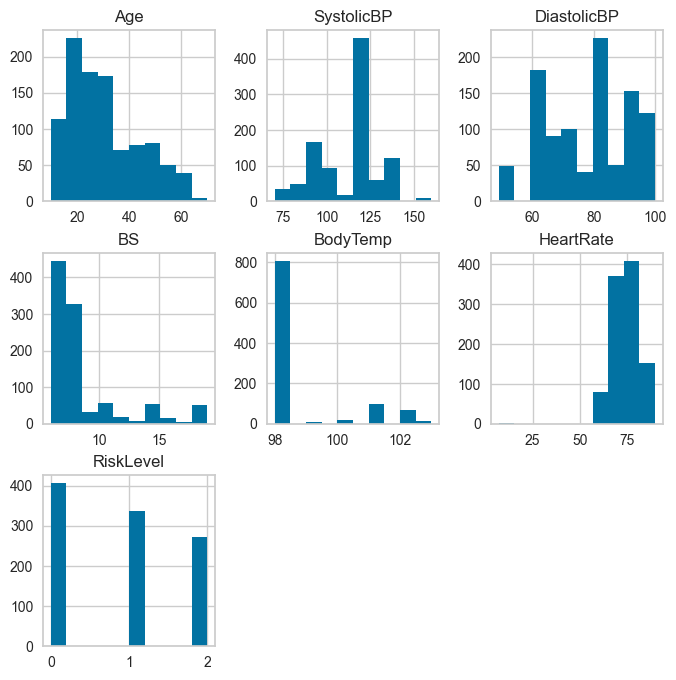

In [195]:
df.hist(figsize=[8, 8])
plt.show();

In [5]:
Q1 = df['BS'].quantile(0.25)
Q3 = df['BS'].quantile(0.75)
IQR = Q3 - Q1
outliers = df[(df['BS'] < (Q1 - 1.5 * IQR)) | (df['BS'] > (Q3 + 1.5 * IQR))]

outliers.RiskLevel.value_counts()

RiskLevel
high risk    174
mid risk      32
low risk       4
Name: count, dtype: int64

In [6]:
outliers[outliers['RiskLevel']=='low risk']

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
465,48,120,80,11.0,98.0,88,low risk
478,48,120,80,11.0,98.0,88,low risk
888,48,120,80,11.0,98.0,88,low risk
895,48,120,80,11.0,98.0,88,low risk


In [7]:
df.drop(outliers[outliers['RiskLevel']=='low risk'].index, inplace=True)

In [8]:
Q1 = df['HeartRate'].quantile(0.25)
Q3 = df['HeartRate'].quantile(0.75)
IQR = Q3 - Q1
outliers_HR = df[(df['HeartRate'] < (Q1 - 1.5 * IQR)) | (df['HeartRate'] > (Q3 + 1.5 * IQR))]

outliers_HR

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
499,16,120,75,7.9,98.0,7,low risk
908,16,120,75,7.9,98.0,7,low risk


In [9]:
df.drop(df[df['HeartRate'] <8].index, inplace=True)

In [10]:
mapping = {'high risk': 2, 'low risk': 0, 'mid risk': 1}
df['RiskLevel'] = df['RiskLevel'].replace(mapping)

Лучшая модель на исходом датасете

In [10]:
exp1 = setup(df, target = 'RiskLevel')
best_model = compare_models()

# Обучение выбранной модели
final_model = finalize_model(best_model)

# Оценка модели
evaluate_model(final_model)

,Description,Value
0,Session id,6397
1,Target,RiskLevel
2,Target type,Multiclass
3,Original data shape,"(1008, 7)"
4,Transformed data shape,"(1008, 7)"
5,Transformed train set shape,"(705, 7)"
6,Transformed test set shape,"(303, 7)"
7,Numeric features,6
8,Preprocess,True
9,Imputation type,simple


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.8326,0.9337,0.8326,0.8373,0.8328,0.7452,0.7472,0.0870
rf,Random Forest Classifier,0.8226,0.9338,0.8226,0.8300,0.8237,0.7309,0.7334,0.1090
xgboost,Extreme Gradient Boosting,0.8127,0.9258,0.8127,0.8208,0.8137,0.7156,0.7183,0.0510
lightgbm,Light Gradient Boosting Machine,0.8071,0.9218,0.8071,0.8142,0.8084,0.7068,0.7087,0.3130
gbc,Gradient Boosting Classifier,0.7957,0.9105,0.7957,0.8022,0.7968,0.6894,0.6915,0.1570
dt,Decision Tree Classifier,0.7944,0.8731,0.7944,0.8079,0.7965,0.6870,0.6912,0.0150
knn,K Neighbors Classifier,0.6881,0.8388,0.6881,0.7015,0.6886,0.5219,0.5266,0.0260
qda,Quadratic Discriminant Analysis,0.6369,0.7915,0.6369,0.6529,0.6180,0.4353,0.4596,0.0160
ridge,Ridge Classifier,0.6212,0.0000,0.6212,0.6135,0.5944,0.4128,0.4332,0.0140
lr,Logistic Regression,0.6113,0.7905,0.6113,0.6085,0.6021,0.4048,0.4110,0.9760


Processing:   0%|          | 0/65 [00:00<?, ?it/s]

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [11]:
best_classif = pull()
Baseline = best_classif[:1]

Добавление гемодинамических параметров

In [50]:
df['MeanBP']=(2*df.DiastolicBP + df.SystolicBP)/3

df['HaemP'] = df.DiastolicBP + ((df.SystolicBP - df.DiastolicBP) / 20) * (df.HeartRate.apply(sqrt))

# Вегетативный показатель кровообращения
df['vpk']=(df.HeartRate/ 60 )**2 * df.HaemP /df.SystolicBP

In [13]:
df

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel,MeanBP,HaemP,vpk
0,25,130,80,15.0,98.0,86,2,96.666667,103.184046,1.630661
1,35,140,90,13.0,98.0,70,2,106.666667,110.916501,1.078355
2,29,90,70,8.0,100.0,80,2,76.666667,78.944272,1.559393
3,30,140,85,7.0,98.0,70,2,103.333333,108.008151,1.050079
4,35,120,60,6.1,98.0,76,0,80.000000,86.153394,1.151903
...,...,...,...,...,...,...,...,...,...,...
1009,22,120,60,15.0,98.0,80,2,80.000000,86.832816,1.286412
1010,55,120,90,18.0,98.0,60,2,100.000000,101.618950,0.846825
1011,35,85,60,19.0,98.0,86,2,68.333333,71.592023,1.730375
1012,43,120,90,18.0,98.0,70,2,100.000000,102.549900,1.163182


In [14]:
exp1 = setup(df, target = 'RiskLevel')
best_model = compare_models()

final_model = finalize_model(best_model)

evaluate_model(final_model)

,Description,Value
0,Session id,8257
1,Target,RiskLevel
2,Target type,Multiclass
3,Original data shape,"(1008, 10)"
4,Transformed data shape,"(1008, 10)"
5,Transformed train set shape,"(705, 10)"
6,Transformed test set shape,"(303, 10)"
7,Numeric features,9
8,Preprocess,True
9,Imputation type,simple


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.8144,0.9351,0.8144,0.8207,0.8143,0.7184,0.7210,0.3140
rf,Random Forest Classifier,0.8143,0.9348,0.8143,0.8213,0.8140,0.7183,0.7216,0.1230
xgboost,Extreme Gradient Boosting,0.8129,0.9366,0.8129,0.8215,0.8129,0.7164,0.7201,0.0500
et,Extra Trees Classifier,0.8057,0.9296,0.8057,0.8124,0.8052,0.7050,0.7083,0.0850
dt,Decision Tree Classifier,0.7974,0.8888,0.7974,0.8079,0.7977,0.6929,0.6973,0.0150
gbc,Gradient Boosting Classifier,0.7858,0.9179,0.7858,0.7917,0.7857,0.6742,0.6766,0.1950
knn,K Neighbors Classifier,0.6584,0.8351,0.6584,0.6684,0.6549,0.4747,0.4812,0.0280
ridge,Ridge Classifier,0.6498,0.0000,0.6498,0.6546,0.6371,0.4588,0.4711,0.0130
qda,Quadratic Discriminant Analysis,0.6401,0.8061,0.6401,0.6533,0.6256,0.4422,0.4589,0.0160
lda,Linear Discriminant Analysis,0.6399,0.8020,0.6399,0.6564,0.6380,0.4452,0.4511,0.0150


Processing:   0%|          | 0/65 [00:00<?, ?it/s]

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [15]:
best_classif = pull()
aug_haem = best_classif[:1]

Гемодинамические параметры + масштабирование

In [16]:
y=df.RiskLevel

In [17]:
y.isna().any()

False

In [18]:
X=df.drop(['RiskLevel'], axis=1)
scaler = StandardScaler()

X_scaled = scaler.fit_transform(X)


In [19]:
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)
X_scaled_df

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,MeanBP,HaemP,vpk
0,-0.359043,0.913256,0.255104,1.904396,-0.486999,1.552472,0.545984,0.726646,1.315060
1,0.384720,1.455497,0.973585,1.298036,-0.486999,-0.585358,1.230076,1.241350,-0.696236
2,-0.061538,-1.255707,-0.463378,-0.217866,0.968798,0.750786,-0.822200,-0.886853,1.055529
3,0.012839,1.455497,0.614344,-0.521046,-0.486999,-0.585358,1.002046,1.047759,-0.799205
4,0.384720,0.371015,-1.181859,-0.793908,-0.486999,0.216328,-0.594169,-0.406984,-0.428401
...,...,...,...,...,...,...,...,...,...
1003,-0.582172,0.371015,-1.181859,1.904396,-0.486999,0.750786,-0.594169,-0.361759,0.061432
1004,1.872247,0.371015,0.973585,2.813937,-0.486999,-1.921502,0.774015,0.622467,-1.539385
1005,0.384720,-1.526827,-1.181859,3.117117,-0.486999,1.552472,-1.392277,-1.376249,1.678181
1006,0.979731,0.371015,0.973585,2.813937,-0.486999,-0.585358,0.774015,0.684435,-0.387327


In [20]:
X_scaled_df['RiskLevel'] = y.values

In [21]:
na_mask = X_scaled_df.isna().any(axis=1)

rows_with_na = X_scaled_df[na_mask]
rows_with_na

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,MeanBP,HaemP,vpk,RiskLevel


In [22]:
exp1 = setup(X_scaled_df, target = 'RiskLevel')
best_model = compare_models()

final_model = finalize_model(best_model)

evaluate_model(final_model)

,Description,Value
0,Session id,5008
1,Target,RiskLevel
2,Target type,Multiclass
3,Original data shape,"(1008, 10)"
4,Transformed data shape,"(1008, 10)"
5,Transformed train set shape,"(705, 10)"
6,Transformed test set shape,"(303, 10)"
7,Numeric features,9
8,Preprocess,True
9,Imputation type,simple


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
xgboost,Extreme Gradient Boosting,0.8199,0.9394,0.8199,0.8267,0.8206,0.7272,0.7297,0.0530
rf,Random Forest Classifier,0.8156,0.9335,0.8156,0.8210,0.8159,0.7205,0.7227,0.1060
lightgbm,Light Gradient Boosting Machine,0.8099,0.9385,0.8099,0.8155,0.8099,0.7119,0.7143,0.3150
gbc,Gradient Boosting Classifier,0.8071,0.9301,0.8071,0.8128,0.8070,0.7070,0.7096,0.1640
dt,Decision Tree Classifier,0.8042,0.8960,0.8042,0.8117,0.8047,0.7034,0.7064,0.0160
et,Extra Trees Classifier,0.8029,0.9310,0.8029,0.8080,0.8032,0.7009,0.7030,0.0870
knn,K Neighbors Classifier,0.6666,0.8414,0.6666,0.6849,0.6674,0.4881,0.4924,0.0290
ridge,Ridge Classifier,0.6228,0.0000,0.6228,0.6100,0.5982,0.4173,0.4330,0.0140
qda,Quadratic Discriminant Analysis,0.6227,0.7773,0.6227,0.6327,0.6053,0.4160,0.4332,0.0140
nb,Naive Bayes,0.6141,0.7700,0.6141,0.6112,0.5929,0.4039,0.4200,0.0150


Processing:   0%|          | 0/65 [00:00<?, ?it/s]

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [23]:
best_classif = pull()
aug_haem_scaled = best_classif[:1]

Гемодинамические параметры + SMOTE + масштабирование 

In [11]:
df['MeanBP']=(2*df.DiastolicBP + df.SystolicBP)/3

df['HaemP'] = df.DiastolicBP + ((df.SystolicBP - df.DiastolicBP) / 20) * (df.HeartRate.apply(sqrt))

df['vpk']=(df.HeartRate/ 60 )**2 * df.HaemP /df.SystolicBP

df['HighGTT']=(df.BS>10)*1
df.HighGTT.value_counts()


HighGTT
0    806
1    202
Name: count, dtype: int64

In [12]:
df['HighTemp']=(df.BodyTemp>98)*1
df.HighTemp.value_counts()

HighTemp
0    798
1    210
Name: count, dtype: int64

In [13]:
df['Older']=(df.Age > 32)*1

In [27]:
df

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel,MeanBP,HaemP,vpk,HighGTT,HighTemp,Older
0,25,130,80,15.0,98.0,86,2,96.666667,103.184046,1.630661,1,0,0
1,35,140,90,13.0,98.0,70,2,106.666667,110.916501,1.078355,1,0,1
2,29,90,70,8.0,100.0,80,2,76.666667,78.944272,1.559393,0,1,0
3,30,140,85,7.0,98.0,70,2,103.333333,108.008151,1.050079,0,0,0
4,35,120,60,6.1,98.0,76,0,80.000000,86.153394,1.151903,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1009,22,120,60,15.0,98.0,80,2,80.000000,86.832816,1.286412,1,0,0
1010,55,120,90,18.0,98.0,60,2,100.000000,101.618950,0.846825,1,0,1
1011,35,85,60,19.0,98.0,86,2,68.333333,71.592023,1.730375,1,0,1
1012,43,120,90,18.0,98.0,70,2,100.000000,102.549900,1.163182,1,0,1


In [73]:
y=df.RiskLevel
X=df.drop(['RiskLevel'], axis=1)
# Создаем экземпляр SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

In [29]:
X_resampled.shape

(1200, 12)

In [30]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_resampled)

In [31]:
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

In [32]:
X_scaled_df['RiskLevel']=y_resampled.values

In [33]:
exp1 = setup(X_scaled_df, target = 'RiskLevel')
best_model = compare_models()

final_model = finalize_model(best_model)

evaluate_model(final_model)

,Description,Value
0,Session id,1814
1,Target,RiskLevel
2,Target type,Multiclass
3,Original data shape,"(1200, 13)"
4,Transformed data shape,"(1200, 13)"
5,Transformed train set shape,"(840, 13)"
6,Transformed test set shape,"(360, 13)"
7,Numeric features,12
8,Preprocess,True
9,Imputation type,simple


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.8405,0.9516,0.8405,0.8474,0.8407,0.7607,0.7635,0.0920
xgboost,Extreme Gradient Boosting,0.8405,0.9496,0.8405,0.8469,0.8405,0.7607,0.7635,0.0580
lightgbm,Light Gradient Boosting Machine,0.8405,0.9538,0.8405,0.8447,0.8400,0.7607,0.7629,0.2610
rf,Random Forest Classifier,0.8381,0.9527,0.8381,0.8430,0.8380,0.7571,0.7594,0.1270
dt,Decision Tree Classifier,0.8321,0.9140,0.8321,0.8408,0.8332,0.7482,0.7511,0.0180
gbc,Gradient Boosting Classifier,0.8274,0.9390,0.8274,0.8313,0.8276,0.7411,0.7427,0.1830
knn,K Neighbors Classifier,0.6857,0.8768,0.6857,0.7027,0.6863,0.5286,0.5351,0.0260
ada,Ada Boost Classifier,0.6738,0.7637,0.6738,0.7001,0.6791,0.5107,0.5159,0.0520
ridge,Ridge Classifier,0.6095,0.0000,0.6095,0.6141,0.5977,0.4143,0.4255,0.0120
lr,Logistic Regression,0.6024,0.8040,0.6024,0.6002,0.5950,0.4036,0.4085,0.0230


Processing:   0%|          | 0/65 [00:00<?, ?it/s]

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [34]:
best_classif = pull()
aug_haem_smote_scaled = best_classif[:1]

Добавить МОК

In [14]:
df['MOK']= (100+0.5*(df.SystolicBP-df.DiastolicBP)-0.6*df.DiastolicBP-0.6*df.Age)*df.HeartRate

In [75]:
y=df.RiskLevel
X=df.drop(['RiskLevel'], axis=1)
# Создаем экземпляр SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_resampled)

X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

X_scaled_df['RiskLevel']=y_resampled.values

In [76]:
exp1 = setup(X_scaled_df, target = 'RiskLevel')
best_model = compare_models()

final_model = finalize_model(best_model)

evaluate_model(final_model)

,Description,Value
0,Session id,6915
1,Target,RiskLevel
2,Target type,Multiclass
3,Original data shape,"(1212, 14)"
4,Transformed data shape,"(1212, 14)"
5,Transformed train set shape,"(848, 14)"
6,Transformed test set shape,"(364, 14)"
7,Numeric features,13
8,Preprocess,True
9,Imputation type,simple


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.8467,0.9500,0.8467,0.8514,0.8463,0.7700,0.7724,0.2200
xgboost,Extreme Gradient Boosting,0.8455,0.9494,0.8455,0.8494,0.8451,0.7682,0.7703,0.0670
rf,Random Forest Classifier,0.8325,0.9519,0.8325,0.8385,0.8323,0.7488,0.7516,0.1090
et,Extra Trees Classifier,0.8301,0.9447,0.8301,0.8360,0.8302,0.7452,0.7477,0.0880
dt,Decision Tree Classifier,0.8289,0.9026,0.8289,0.8368,0.8282,0.7434,0.7473,0.0150
gbc,Gradient Boosting Classifier,0.8124,0.9363,0.8124,0.8161,0.8117,0.7185,0.7209,0.2010
ada,Ada Boost Classifier,0.7052,0.7680,0.7052,0.7235,0.7072,0.5577,0.5637,0.0520
knn,K Neighbors Classifier,0.7028,0.8657,0.7028,0.7187,0.7058,0.5541,0.5578,0.0240
lr,Logistic Regression,0.6261,0.8156,0.6261,0.6249,0.6216,0.4389,0.4417,0.0200
ridge,Ridge Classifier,0.6226,0.0000,0.6226,0.6239,0.6090,0.4336,0.4442,0.0130


Processing:   0%|          | 0/65 [00:00<?, ?it/s]

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [77]:
best_classif = pull()
aug_haem_MOK_smote_scaled = best_classif[:1]

In [84]:
best_model_hyperparams = best_model.get_params()

In [85]:
best_model_hyperparams

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': None,
 'random_state': 6915,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

In [79]:
final_model = finalize_model(best_model)


In [83]:
final_model

Pipeline(memory=Memory(location=None),
         steps=[('numerical_imputer',
                 TransformerWrapper(exclude=None,
                                    include=['Age', 'SystolicBP', 'DiastolicBP',
                                             'BS', 'BodyTemp', 'HeartRate',
                                             'MeanBP', 'HaemP', 'vpk',
                                             'HighGTT', 'HighTemp', 'Older',
                                             'MOK'],
                                    transformer=SimpleImputer(add_indicator=False,
                                                              copy=True,
                                                              fill_value=None,
                                                              keep_empty_features=False,
                                                              missing_values=nan,
                                                              strate...
                 LGBMClassifier(boosting_type='gbdt', class_weight=None,
                                colsample_bytree=1.0, importance_type='split',
                                learning_rate=0.1, max_depth=-1,
                                min_child_samples=20, min_child_weight=0.001,
                                min_split_gain=0.0, n_estimators=100, n_jobs=-1,
                                num_leaves=31, objective=None,
                                random_state=6915, reg_alpha=0.0,
                                reg_lambda=0.0, subsample=1.0,
                                subsample_for_bin=200000, subsample_freq=0))],
         verbose=False)

PS Неудачные эксперименты:

Без отклоняющихся значений

In [22]:
df['Age_groups'] = pd.cut(df.Age, bins = [0, 14, 18, 26, 39, 100], labels = ['Age_less 14', 'Age_14-18', 'Age_19-26', 'Age_27-39', 'Age_40-70'])
df['SystolicBP_groups'] = pd.cut(df.SystolicBP, bins = [69, 80, 90, 100, 120, 140, 180], labels = ['SystolicBP_70-80', 'SystolicBP_80-90', 'SystolicBP_90-100', 'SystolicBP_100-120', 'SystolicBP_120-140', 'SystolicBP_140-180'])
df['DiastolicBP_groups'] = pd.cut(df.DiastolicBP, bins = [45, 65, 80, 90, 100], labels = ['DiastolicBP_less65', 'DiastolicBP_65-80', 'DiastolicBP_80-90', 'DiastolicBP_90-100'])
df['TempC']=round((df.BodyTemp-32)*5/9, 2)
df['TempC_groups'] = pd.cut(df.TempC, bins = [36.4, 36.7, 37, 38, 40], labels = ['TempC_norm', 'TempC_37', 'TempC_38', 'TempC_39'])
df['HeartRate_groups'] = pd.cut(df.HeartRate, bins = [5, 40, 60, 80, 90], labels = ['HR_less40', 'HR_40-60', 'HR_60-80', 'HR_80-90'])
df['BS_groups'] = pd.cut(df.BS, bins = [4, 6, 8, 10, 20], labels = [ 'BG_norm', 'BG_6-8', 'BG_8-10','BG11-20'])
df['BP_differ']=df['SystolicBP']-df['DiastolicBP']
df['BP_differ_groups'] = pd.cut(df.BP_differ, bins = [0, 10, 20, 30, 40, 50, 100], labels = ['BPD_less10', 'BPD10-20','BPD20-30', 'BPD30-40', 'BPD40-50','BPD_more50'])

In [538]:
df

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel,Age_groups,SystolicBP_groups,DiastolicBP_groups,TempC,TempC_groups,HeartRate_groups,BS_groups,BP_differ,BP_differ_groups
0,25,130,80,15.0,98.0,86,2,Age_19-26,SystolicBP_120-140,DiastolicBP_65-80,36.67,TempC_norm,HR_80-90,BG11-20,50,BPD40-50
1,35,140,90,13.0,98.0,70,2,Age_27-39,SystolicBP_120-140,DiastolicBP_80-90,36.67,TempC_norm,HR_60-80,BG11-20,50,BPD40-50
2,29,90,70,8.0,100.0,80,2,Age_27-39,SystolicBP_80-90,DiastolicBP_65-80,37.78,TempC_38,HR_60-80,BG_6-8,20,BPD10-20
3,30,140,85,7.0,98.0,70,2,Age_27-39,SystolicBP_120-140,DiastolicBP_80-90,36.67,TempC_norm,HR_60-80,BG_6-8,55,BPD_more50
4,35,120,60,6.1,98.0,76,0,Age_27-39,SystolicBP_100-120,DiastolicBP_less65,36.67,TempC_norm,HR_60-80,BG_6-8,60,BPD_more50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1009,22,120,60,15.0,98.0,80,2,Age_19-26,SystolicBP_100-120,DiastolicBP_less65,36.67,TempC_norm,HR_60-80,BG11-20,60,BPD_more50
1010,55,120,90,18.0,98.0,60,2,Age_40-70,SystolicBP_100-120,DiastolicBP_80-90,36.67,TempC_norm,HR_40-60,BG11-20,30,BPD20-30
1011,35,85,60,19.0,98.0,86,2,Age_27-39,SystolicBP_80-90,DiastolicBP_less65,36.67,TempC_norm,HR_80-90,BG11-20,25,BPD20-30
1012,43,120,90,18.0,98.0,70,2,Age_40-70,SystolicBP_100-120,DiastolicBP_80-90,36.67,TempC_norm,HR_60-80,BG11-20,30,BPD20-30


In [15]:
category_columns = df.select_dtypes(include=['category'])
for column in category_columns:
    print(df[column].value_counts().to_string())
    print()

Age_groups
Age_19-26      297
Age_27-39      253
Age_40-70      248
Age_14-18      156
Age_less 14     54

SystolicBP_groups
SystolicBP_100-120    470
SystolicBP_80-90      199
SystolicBP_120-140    184
SystolicBP_90-100     106
SystolicBP_70-80       39
SystolicBP_140-180     10

DiastolicBP_groups
DiastolicBP_65-80     364
DiastolicBP_less65    318
DiastolicBP_80-90     203
DiastolicBP_90-100    123

TempC_groups
TempC_norm    798
TempC_39      177
TempC_38       30
TempC_37        3

HeartRate_groups
HR_60-80     786
HR_80-90     148
HR_40-60      74
HR_less40      0

BS_groups
BG_6-8     750
BG11-20    202
BG_8-10     35
BG_norm     21

BP_differ_groups
BPD20-30      374
BPD30-40      347
BPD40-50      116
BPD_more50    107
BPD10-20       52
BPD_less10     12



In [24]:
df[(df['RiskLevel'] == 'low risk') & (df['BS_groups'] == 'BG11-20')]

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel,Age_groups,SystolicBP_groups,DiastolicBP_groups,TempC,TempC_groups,HeartRate_groups,BS_groups,BP_differ,BP_differ_groups


In [541]:
indices_to_drop = df[(df['RiskLevel'] == 'low risk') & (df['BS_groups'] == 'BG11-20')].index
df.drop(indices_to_drop, inplace=True)

In [26]:
df[(df['RiskLevel'] == 'low risk') & (df['TempC_groups'] == 'TempC_39') & (df['BP_differ']<30)]

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel,Age_groups,SystolicBP_groups,DiastolicBP_groups,TempC,TempC_groups,HeartRate_groups,BS_groups,BP_differ,BP_differ_groups
338,70,85,60,6.9,102.0,70,low risk,Age_40-70,SystolicBP_80-90,DiastolicBP_less65,38.89,TempC_39,HR_60-80,BG_6-8,25,BPD20-30
493,17,85,60,7.9,102.0,86,low risk,Age_14-18,SystolicBP_80-90,DiastolicBP_less65,38.89,TempC_39,HR_80-90,BG_6-8,25,BPD20-30
510,17,90,63,7.5,101.0,70,low risk,Age_14-18,SystolicBP_80-90,DiastolicBP_less65,38.33,TempC_39,HR_60-80,BG_6-8,27,BPD20-30
513,19,90,65,7.5,101.0,70,low risk,Age_19-26,SystolicBP_80-90,DiastolicBP_less65,38.33,TempC_39,HR_60-80,BG_6-8,25,BPD20-30
523,17,85,60,7.5,102.0,86,low risk,Age_14-18,SystolicBP_80-90,DiastolicBP_less65,38.89,TempC_39,HR_80-90,BG_6-8,25,BPD20-30
561,13,90,65,7.5,101.0,80,low risk,Age_less 14,SystolicBP_80-90,DiastolicBP_less65,38.33,TempC_39,HR_60-80,BG_6-8,25,BPD20-30
563,17,90,65,7.5,103.0,67,low risk,Age_14-18,SystolicBP_80-90,DiastolicBP_less65,39.44,TempC_39,HR_60-80,BG_6-8,25,BPD20-30
571,17,85,60,7.5,102.0,86,low risk,Age_14-18,SystolicBP_80-90,DiastolicBP_less65,38.89,TempC_39,HR_80-90,BG_6-8,25,BPD20-30
902,17,85,60,7.9,102.0,86,low risk,Age_14-18,SystolicBP_80-90,DiastolicBP_less65,38.89,TempC_39,HR_80-90,BG_6-8,25,BPD20-30
912,17,90,63,7.5,101.0,70,low risk,Age_14-18,SystolicBP_80-90,DiastolicBP_less65,38.33,TempC_39,HR_60-80,BG_6-8,27,BPD20-30


In [27]:
indices_to_drop = df[(df['RiskLevel'] == 'low risk') & (df['TempC_groups'] == 'TempC_39') & (df['BP_differ']<30)].index
df.drop(indices_to_drop, inplace=True)

In [28]:
df[df['BP_differ_groups']=='BPD_less10']

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel,Age_groups,SystolicBP_groups,DiastolicBP_groups,TempC,TempC_groups,HeartRate_groups,BS_groups,BP_differ,BP_differ_groups
30,20,100,90,7.1,98.0,88,low risk,Age_19-26,SystolicBP_90-100,DiastolicBP_80-90,36.67,TempC_norm,HR_80-90,BG_6-8,10,BPD_less10
159,25,100,90,7.5,98.0,76,low risk,Age_19-26,SystolicBP_90-100,DiastolicBP_80-90,36.67,TempC_norm,HR_60-80,BG_6-8,10,BPD_less10
172,20,100,90,7.1,98.0,88,low risk,Age_19-26,SystolicBP_90-100,DiastolicBP_80-90,36.67,TempC_norm,HR_80-90,BG_6-8,10,BPD_less10
255,25,100,90,6.9,98.0,76,low risk,Age_19-26,SystolicBP_90-100,DiastolicBP_80-90,36.67,TempC_norm,HR_60-80,BG_6-8,10,BPD_less10
268,20,100,90,7.0,98.0,88,low risk,Age_19-26,SystolicBP_90-100,DiastolicBP_80-90,36.67,TempC_norm,HR_80-90,BG_6-8,10,BPD_less10
355,25,100,90,6.9,98.0,76,high risk,Age_19-26,SystolicBP_90-100,DiastolicBP_80-90,36.67,TempC_norm,HR_60-80,BG_6-8,10,BPD_less10
544,20,100,90,7.5,98.0,88,low risk,Age_19-26,SystolicBP_90-100,DiastolicBP_80-90,36.67,TempC_norm,HR_80-90,BG_6-8,10,BPD_less10
589,20,100,90,7.5,98.0,88,mid risk,Age_19-26,SystolicBP_90-100,DiastolicBP_80-90,36.67,TempC_norm,HR_80-90,BG_6-8,10,BPD_less10
653,15,76,68,7.0,98.0,77,low risk,Age_14-18,SystolicBP_70-80,DiastolicBP_65-80,36.67,TempC_norm,HR_60-80,BG_6-8,8,BPD_less10
698,15,76,68,7.0,98.0,77,low risk,Age_14-18,SystolicBP_70-80,DiastolicBP_65-80,36.67,TempC_norm,HR_60-80,BG_6-8,8,BPD_less10


In [29]:
indices_to_drop =df[df['BP_differ_groups']=='BPD_less10'].index
df.drop(indices_to_drop, inplace=True)

In [30]:
df[(df['RiskLevel'] == 'low risk') & (df['BP_differ_groups'] == 'BPD10-20')]

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel,Age_groups,SystolicBP_groups,DiastolicBP_groups,TempC,TempC_groups,HeartRate_groups,BS_groups,BP_differ,BP_differ_groups
19,10,70,50,6.9,98.0,70,low risk,Age_less 14,SystolicBP_70-80,DiastolicBP_less65,36.67,TempC_norm,HR_60-80,BG_6-8,20,BPD10-20
31,23,100,85,7.1,98.0,66,low risk,Age_19-26,SystolicBP_90-100,DiastolicBP_80-90,36.67,TempC_norm,HR_60-80,BG_6-8,15,BPD10-20
42,25,90,70,6.1,98.0,80,low risk,Age_19-26,SystolicBP_80-90,DiastolicBP_65-80,36.67,TempC_norm,HR_60-80,BG_6-8,20,BPD10-20
61,15,80,60,7.0,98.0,80,low risk,Age_14-18,SystolicBP_70-80,DiastolicBP_less65,36.67,TempC_norm,HR_60-80,BG_6-8,20,BPD10-20
146,15,80,60,6.7,98.0,80,low risk,Age_14-18,SystolicBP_70-80,DiastolicBP_less65,36.67,TempC_norm,HR_60-80,BG_6-8,20,BPD10-20
151,21,100,85,6.7,98.0,70,low risk,Age_19-26,SystolicBP_90-100,DiastolicBP_80-90,36.67,TempC_norm,HR_60-80,BG_6-8,15,BPD10-20
154,23,85,65,7.5,98.0,70,low risk,Age_19-26,SystolicBP_80-90,DiastolicBP_less65,36.67,TempC_norm,HR_60-80,BG_6-8,20,BPD10-20
173,23,100,85,7.1,98.0,66,low risk,Age_19-26,SystolicBP_90-100,DiastolicBP_80-90,36.67,TempC_norm,HR_60-80,BG_6-8,15,BPD10-20
194,25,90,70,6.1,98.0,80,low risk,Age_19-26,SystolicBP_80-90,DiastolicBP_65-80,36.67,TempC_norm,HR_60-80,BG_6-8,20,BPD10-20
242,15,80,60,7.0,98.0,80,low risk,Age_14-18,SystolicBP_70-80,DiastolicBP_less65,36.67,TempC_norm,HR_60-80,BG_6-8,20,BPD10-20


In [31]:
indices_to_drop =df[(df['RiskLevel'] == 'low risk') & (df['BP_differ_groups'] == 'BPD10-20')].index
df.drop(indices_to_drop, inplace=True)

In [32]:
df[(df['RiskLevel'] == 'low risk') & (df['SystolicBP_groups'] == 'SystolicBP_70-80')]

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel,Age_groups,SystolicBP_groups,DiastolicBP_groups,TempC,TempC_groups,HeartRate_groups,BS_groups,BP_differ,BP_differ_groups
34,21,75,50,6.1,98.0,70,low risk,Age_19-26,SystolicBP_70-80,DiastolicBP_less65,36.67,TempC_norm,HR_60-80,BG_6-8,25,BPD20-30
48,15,76,49,7.5,98.0,77,low risk,Age_14-18,SystolicBP_70-80,DiastolicBP_less65,36.67,TempC_norm,HR_60-80,BG_6-8,27,BPD20-30
59,15,76,49,6.4,98.0,77,low risk,Age_14-18,SystolicBP_70-80,DiastolicBP_less65,36.67,TempC_norm,HR_60-80,BG_6-8,27,BPD20-30
179,21,75,50,6.1,98.0,70,low risk,Age_19-26,SystolicBP_70-80,DiastolicBP_less65,36.67,TempC_norm,HR_60-80,BG_6-8,25,BPD20-30
204,15,76,49,7.5,98.0,77,low risk,Age_14-18,SystolicBP_70-80,DiastolicBP_less65,36.67,TempC_norm,HR_60-80,BG_6-8,27,BPD20-30
226,15,76,49,6.4,98.0,77,low risk,Age_14-18,SystolicBP_70-80,DiastolicBP_less65,36.67,TempC_norm,HR_60-80,BG_6-8,27,BPD20-30
275,21,75,50,7.7,98.0,60,low risk,Age_19-26,SystolicBP_70-80,DiastolicBP_less65,36.67,TempC_norm,HR_40-60,BG_6-8,25,BPD20-30
300,15,75,49,7.7,98.0,77,low risk,Age_14-18,SystolicBP_70-80,DiastolicBP_less65,36.67,TempC_norm,HR_60-80,BG_6-8,26,BPD20-30
370,21,75,50,7.8,98.0,60,low risk,Age_19-26,SystolicBP_70-80,DiastolicBP_less65,36.67,TempC_norm,HR_40-60,BG_6-8,25,BPD20-30
395,15,76,49,7.8,98.0,77,low risk,Age_14-18,SystolicBP_70-80,DiastolicBP_less65,36.67,TempC_norm,HR_60-80,BG_6-8,27,BPD20-30


In [33]:
indices_to_drop = df[(df['RiskLevel'] == 'low risk') & (df['SystolicBP_groups'] == 'SystolicBP_70-80')].index
df.drop(indices_to_drop, inplace=True)

In [35]:
df[df['HeartRate_groups']=='HR_less40']

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel,Age_groups,SystolicBP_groups,DiastolicBP_groups,TempC,TempC_groups,HeartRate_groups,BS_groups,BP_differ,BP_differ_groups


In [36]:
indices_to_drop = indices_to_drop = df[df['HeartRate_groups']=='HR_less40'].index
df.drop(indices_to_drop, inplace=True)

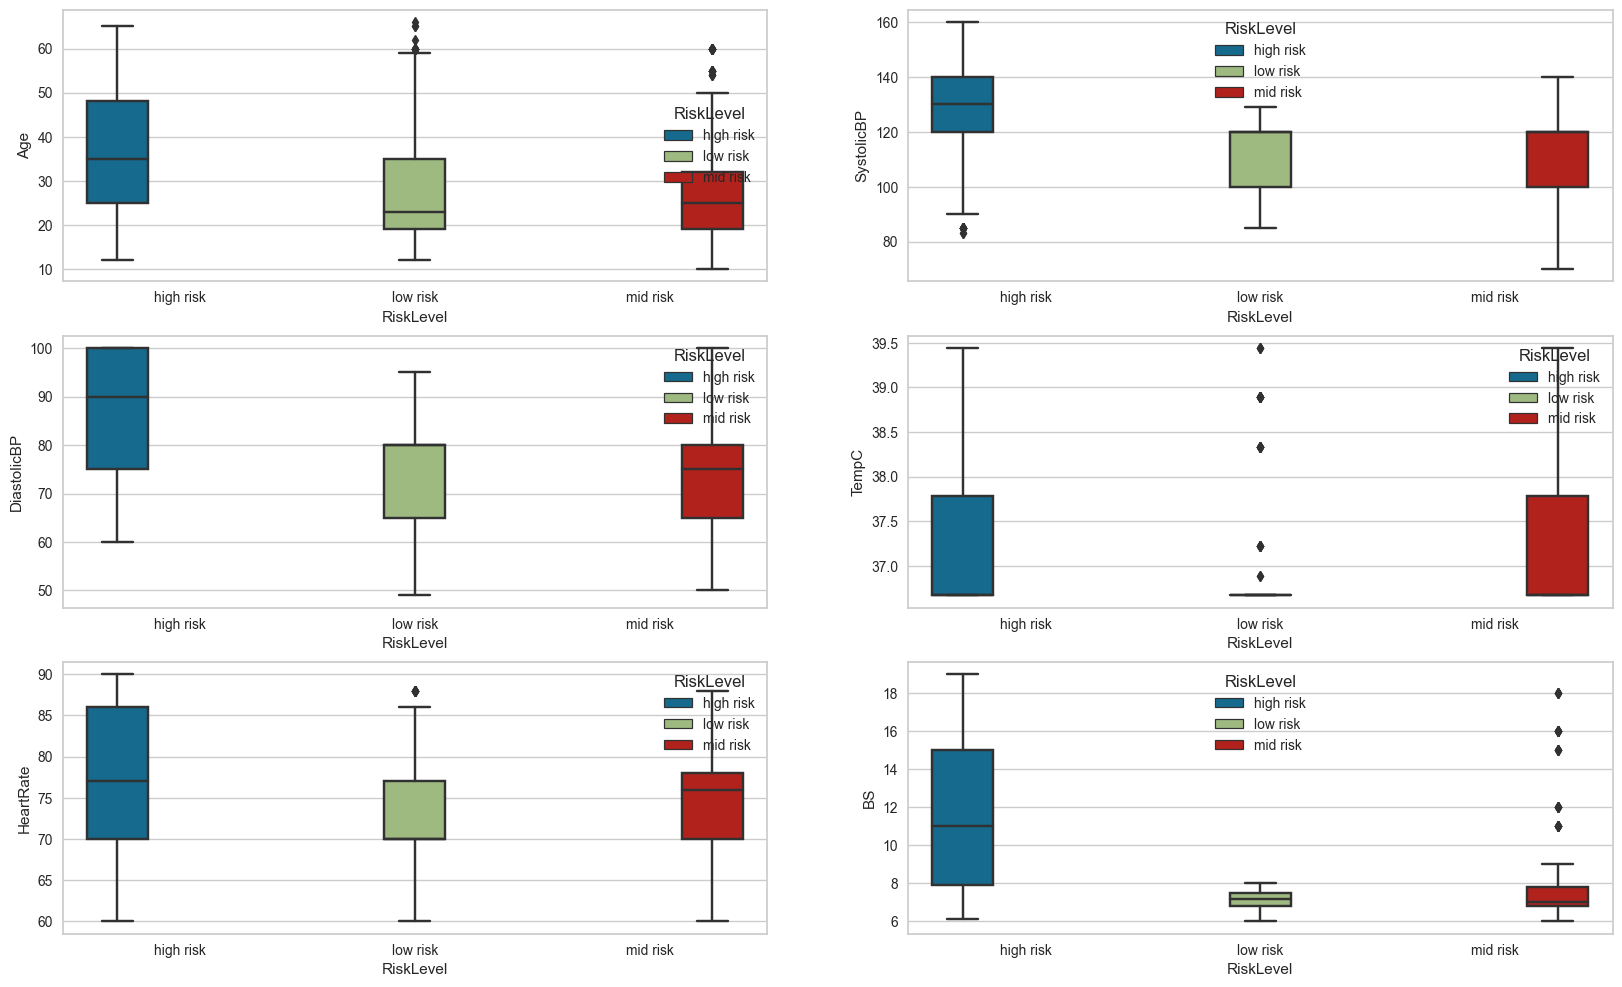

In [36]:
fig, axarr = plt.subplots(3, 2, figsize=(20, 12))

sns.boxplot(y='Age', x='RiskLevel', hue='RiskLevel', data=df, ax=axarr[0, 0])
sns.boxplot(y='SystolicBP', x='RiskLevel', hue='RiskLevel', data=df, ax=axarr[0, 1])
sns.boxplot(y='DiastolicBP', x='RiskLevel', hue='RiskLevel', data=df, ax=axarr[1, 0])
sns.boxplot(y='TempC', x='RiskLevel', hue='RiskLevel', data=df, ax=axarr[1, 1])
sns.boxplot(y='HeartRate', x='RiskLevel', hue='RiskLevel', data=df, ax=axarr[2, 0])
sns.boxplot(y='BS', x='RiskLevel', hue='RiskLevel', data=df, ax=axarr[2, 1])

plt.show();

In [37]:
df.drop(['Age_groups',
 'SystolicBP_groups',
 'DiastolicBP_groups',
 'TempC',
 'TempC_groups',
 'HeartRate_groups',
 'BS_groups',
 'BP_differ',
 'BP_differ_groups'], axis=1, inplace=True)

In [38]:
exp1 = setup(df, target = 'RiskLevel')
best_model = compare_models()

final_model = finalize_model(best_model)

evaluate_model(final_model)

,Description,Value
0,Session id,2242
1,Target,RiskLevel
2,Target type,Multiclass
3,Target mapping,"high risk: 0, low risk: 1, mid risk: 2"
4,Original data shape,"(927, 7)"
5,Transformed data shape,"(927, 7)"
6,Transformed train set shape,"(648, 7)"
7,Transformed test set shape,"(279, 7)"
8,Numeric features,6
9,Preprocess,True


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.7994,0.0000,0.7994,0.8067,0.7976,0.6980,0.7026,0.0820
rf,Random Forest Classifier,0.7979,0.0000,0.7979,0.8054,0.7974,0.6955,0.6992,0.0900
xgboost,Extreme Gradient Boosting,0.7964,0.0000,0.7964,0.8042,0.7955,0.6933,0.6975,0.0510
lightgbm,Light Gradient Boosting Machine,0.7856,0.0000,0.7856,0.7956,0.7850,0.6771,0.6820,0.2210
dt,Decision Tree Classifier,0.7685,0.0000,0.7685,0.7784,0.7674,0.6512,0.6566,0.0170
gbc,Gradient Boosting Classifier,0.7593,0.0000,0.7593,0.7647,0.7588,0.6373,0.6401,0.1720
knn,K Neighbors Classifier,0.6867,0.0000,0.6867,0.6915,0.6835,0.5280,0.5323,0.0220
qda,Quadratic Discriminant Analysis,0.6251,0.0000,0.6251,0.6445,0.6080,0.4354,0.4572,0.0160
ridge,Ridge Classifier,0.6189,0.0000,0.6189,0.6182,0.6019,0.4267,0.4408,0.0130
nb,Naive Bayes,0.6081,0.0000,0.6081,0.6163,0.5740,0.4094,0.4439,0.0160


Processing:   0%|          | 0/65 [00:00<?, ?it/s]

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [39]:
best_classif = pull()
droped_extreme_values = best_classif[:1]

Без дубликатов

In [46]:
df.shape

(927, 7)

In [47]:
df=df.drop_duplicates()
df.shape

(404, 7)

In [48]:
exp1 = setup(df, target = 'RiskLevel')
best_model = compare_models()

final_model = finalize_model(best_model)

evaluate_model(final_model)

,Description,Value
0,Session id,2293
1,Target,RiskLevel
2,Target type,Multiclass
3,Target mapping,"high risk: 0, low risk: 1, mid risk: 2"
4,Original data shape,"(404, 7)"
5,Transformed data shape,"(404, 7)"
6,Transformed train set shape,"(282, 7)"
7,Transformed test set shape,"(122, 7)"
8,Numeric features,6
9,Preprocess,True


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.6846,0.0000,0.6846,0.6754,0.6707,0.4975,0.5051,0.1480
gbc,Gradient Boosting Classifier,0.6807,0.0000,0.6807,0.6713,0.6652,0.4908,0.5003,0.2640
lightgbm,Light Gradient Boosting Machine,0.6777,0.0000,0.6777,0.6808,0.6724,0.4940,0.4998,0.2290
xgboost,Extreme Gradient Boosting,0.6776,0.0000,0.6776,0.6796,0.6686,0.4937,0.5025,0.0690
et,Extra Trees Classifier,0.6600,0.0000,0.6600,0.6594,0.6517,0.4625,0.4677,0.1120
dt,Decision Tree Classifier,0.6597,0.0000,0.6597,0.6689,0.6595,0.4718,0.4758,0.0220
qda,Quadratic Discriminant Analysis,0.6350,0.0000,0.6350,0.6303,0.6128,0.4063,0.4194,0.0210
nb,Naive Bayes,0.6346,0.0000,0.6346,0.6249,0.6022,0.3921,0.4186,0.0220
lr,Logistic Regression,0.6310,0.0000,0.6310,0.5894,0.5791,0.3880,0.4167,0.1400
lda,Linear Discriminant Analysis,0.6099,0.0000,0.6099,0.5940,0.5549,0.3461,0.3824,0.0230


Processing:   0%|          | 0/65 [00:00<?, ?it/s]

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

Разреженная матрица

In [57]:
age_dummies = pd.get_dummies(df['Age_groups'])
df = pd.concat([df, age_dummies], axis=1)
df[['Age_less 14', 'Age_14-18', 'Age_19-26', 'Age_27-39', 'Age_40-70']] = df[['Age_less 14', 'Age_14-18', 'Age_19-26', 'Age_27-39', 'Age_40-70']].astype(int)

In [58]:
systolic_dummies = pd.get_dummies(df['SystolicBP_groups'])
df = pd.concat([df, systolic_dummies], axis=1)

df[['SystolicBP_70-80',
 'SystolicBP_80-90',
 'SystolicBP_90-100',
 'SystolicBP_100-120',
 'SystolicBP_120-140',
 'SystolicBP_140-180']] = df[[ 'SystolicBP_70-80',
 'SystolicBP_80-90',
 'SystolicBP_90-100',
 'SystolicBP_100-120',
 'SystolicBP_120-140',
 'SystolicBP_140-180']].astype(int)

In [59]:
dyastolic_dummies = pd.get_dummies(df['DiastolicBP_groups'])
df = pd.concat([df, dyastolic_dummies], axis=1)

df[[ 'DiastolicBP_less65',
 'DiastolicBP_65-80',
 'DiastolicBP_80-90',
 'DiastolicBP_90-100']] = df[['DiastolicBP_less65',
 'DiastolicBP_65-80',
 'DiastolicBP_80-90',
 'DiastolicBP_90-100']].astype(int)

In [60]:
temp_dummies = pd.get_dummies(df['TempC_groups'])
df = pd.concat([df, temp_dummies], axis=1)


df[['TempC_norm',
 'TempC_37',
 'TempC_38',
 'TempC_39']] = df[['TempC_norm',
 'TempC_37',
 'TempC_38',
 'TempC_39']].astype(int)

In [61]:
heart_dummies = pd.get_dummies(df['HeartRate_groups'])
df = pd.concat([df, heart_dummies], axis=1)

df[['HR_less40',
 'HR_40-60',
 'HR_60-80',
 'HR_80-90']] = df[['HR_less40',
 'HR_40-60',
 'HR_60-80',
 'HR_80-90']].astype(int)

In [62]:
BS_dummies = pd.get_dummies(df['BS_groups'])
df = pd.concat([df, BS_dummies], axis=1)

df[['BG_norm',
 'BG_6-8',
 'BG_8-10',
 'BG11-20']] = df[['BG_norm',
 'BG_6-8',
 'BG_8-10',
 'BG11-20']].astype(int)

In [63]:
BPdif_dummies = pd.get_dummies(df['BP_differ_groups'])
df = pd.concat([df, BPdif_dummies], axis=1)

df[[ 'BPD_less10',
 'BPD10-20',
 'BPD20-30',
 'BPD30-40',
 'BPD40-50',
 'BPD_more50']] = df[[ 'BPD_less10',
 'BPD10-20',
 'BPD20-30',
 'BPD30-40',
 'BPD40-50',
 'BPD_more50']].astype(int)

In [64]:
category_columns = df.select_dtypes(include=['category'])
for column in category_columns:
    df.drop([column], axis =1, inplace=True)

In [65]:
df

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel,TempC,BP_differ,Age_less 14,...,BG_norm,BG_6-8,BG_8-10,BG11-20,BPD_less10,BPD10-20,BPD20-30,BPD30-40,BPD40-50,BPD_more50
0,25,130,80,15.0,98.0,86,high risk,36.67,50,0,...,0,0,0,1,0,0,0,0,1,0
1,35,140,90,13.0,98.0,70,high risk,36.67,50,0,...,0,0,0,1,0,0,0,0,1,0
2,29,90,70,8.0,100.0,80,high risk,37.78,20,0,...,0,1,0,0,0,1,0,0,0,0
3,30,140,85,7.0,98.0,70,high risk,36.67,55,0,...,0,1,0,0,0,0,0,0,0,1
4,35,120,60,6.1,98.0,76,low risk,36.67,60,0,...,0,1,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1009,22,120,60,15.0,98.0,80,high risk,36.67,60,0,...,0,0,0,1,0,0,0,0,0,1
1010,55,120,90,18.0,98.0,60,high risk,36.67,30,0,...,0,0,0,1,0,0,1,0,0,0
1011,35,85,60,19.0,98.0,86,high risk,36.67,25,0,...,0,0,0,1,0,0,1,0,0,0
1012,43,120,90,18.0,98.0,70,high risk,36.67,30,0,...,0,0,0,1,0,0,1,0,0,0


In [67]:
exp1 = setup(df, target = 'RiskLevel')
best_model = compare_models()

final_model = finalize_model(best_model)

evaluate_model(final_model)

,Description,Value
0,Session id,2756
1,Target,RiskLevel
2,Target type,Multiclass
3,Target mapping,"high risk: 0, low risk: 1, mid risk: 2"
4,Original data shape,"(1014, 42)"
5,Transformed data shape,"(1014, 42)"
6,Transformed train set shape,"(709, 42)"
7,Transformed test set shape,"(305, 42)"
8,Numeric features,41
9,Preprocess,True


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.8195,0.0000,0.8195,0.8236,0.8189,0.7263,0.7287,0.4000
rf,Random Forest Classifier,0.8110,0.0000,0.8110,0.8169,0.8104,0.7132,0.7166,0.1830
xgboost,Extreme Gradient Boosting,0.8110,0.0000,0.8110,0.8156,0.8104,0.7133,0.7160,0.1250
dt,Decision Tree Classifier,0.8068,0.0000,0.8068,0.8109,0.8063,0.7071,0.7094,0.0330
et,Extra Trees Classifier,0.8054,0.0000,0.8054,0.8103,0.8044,0.7045,0.7077,0.1400
gbc,Gradient Boosting Classifier,0.7786,0.0000,0.7786,0.7837,0.7765,0.6632,0.6674,0.3760
knn,K Neighbors Classifier,0.7152,0.0000,0.7152,0.7224,0.7145,0.5653,0.5686,0.0680
ridge,Ridge Classifier,0.6798,0.0000,0.6798,0.6797,0.6618,0.5046,0.5205,0.0300
lda,Linear Discriminant Analysis,0.6727,0.0000,0.6727,0.6734,0.6598,0.4941,0.5062,0.0320
lr,Logistic Regression,0.6572,0.0000,0.6572,0.6517,0.6339,0.4694,0.4877,0.2150


Processing:   0%|          | 0/65 [00:00<?, ?it/s]

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

Мэпинг вместо разреженной матрицы:

In [73]:
df['Age_groups'] = pd.cut(df.Age, bins = [0, 14, 18, 26, 39, 100], labels = ['1', '2', '3', '4', '5'])


df['SystolicBP_groups'] = pd.cut(df.SystolicBP, bins = [69, 80, 90, 100, 120, 140, 180], labels = ['1', '2', '3', '4', '5', '6'])
df['DiastolicBP_groups'] = pd.cut(df.DiastolicBP, bins = [45, 65, 80, 90, 100], labels = ['1', '2', '3', '4'])

df['TempC']=round((df.BodyTemp-32)*5/9, 2)

df['TempC_groups'] = pd.cut(df.TempC, bins = [36.4, 36.7, 37, 38, 40], labels = ['1', '2', '3', '4'])

df['HeartRate_groups'] = pd.cut(df.HeartRate, bins = [5, 40, 60, 80, 90], labels = ['1', '2', '3', '4'])
df['BS_groups'] = pd.cut(df.BS, bins = [4, 6, 8, 10, 20], labels = [ '1', '2', '3', '4'])

df['BP_differ']=df['SystolicBP']-df['DiastolicBP']
df['BP_differ_groups'] = pd.cut(df.BP_differ, bins = [0, 10, 20, 30, 40, 50, 100], labels = ['1', '2', '3', '4', '5', '6'])

In [77]:
df[['Age_groups', 'SystolicBP_groups', 'DiastolicBP_groups','TempC_groups','HeartRate_groups','BS_groups','BP_differ_groups']] = df[['Age_groups','SystolicBP_groups','DiastolicBP_groups','TempC_groups','HeartRate_groups','BS_groups', 'BP_differ_groups']].astype(int)

In [78]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1014 entries, 0 to 1013
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Age                 1014 non-null   int64  
 1   SystolicBP          1014 non-null   int64  
 2   DiastolicBP         1014 non-null   int64  
 3   BS                  1014 non-null   float64
 4   BodyTemp            1014 non-null   float64
 5   HeartRate           1014 non-null   int64  
 6   RiskLevel           1014 non-null   object 
 7   Age_groups          1014 non-null   int32  
 8   SystolicBP_groups   1014 non-null   int32  
 9   DiastolicBP_groups  1014 non-null   int32  
 10  TempC               1014 non-null   float64
 11  TempC_groups        1014 non-null   int32  
 12  HeartRate_groups    1014 non-null   int32  
 13  BS_groups           1014 non-null   int32  
 14  BP_differ           1014 non-null   int64  
 15  BP_differ_groups    1014 non-null   int32  
dtypes: flo

In [85]:
dff = df.drop(['RiskLevel'], axis=1)
dff.corr()

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,Age_groups,SystolicBP_groups,DiastolicBP_groups,TempC,TempC_groups,HeartRate_groups,BS_groups,BP_differ,BP_differ_groups
Age,1.000000,0.416045,0.398026,0.473284,-0.255323,0.079798,0.911877,0.406283,0.365702,-0.255300,-0.262124,0.083355,0.483988,0.187332,0.171857
SystolicBP,0.416045,1.000000,0.787006,0.425172,-0.286616,-0.023108,0.509637,0.983618,0.731498,-0.286595,-0.286022,-0.013738,0.365760,0.657497,0.604652
DiastolicBP,0.398026,0.787006,1.000000,0.423824,-0.257538,-0.046151,0.452411,0.755863,0.948048,-0.257457,-0.272326,-0.023059,0.393692,0.052613,0.002467
BS,0.473284,0.425172,0.423824,1.000000,-0.103493,0.142867,0.452188,0.394107,0.451268,-0.103468,-0.105349,0.115071,0.900655,0.170598,0.171232
BodyTemp,-0.255323,-0.286616,-0.257538,-0.103493,1.000000,0.098771,-0.341735,-0.279667,-0.306866,0.999999,0.975800,0.116350,-0.059816,-0.149405,-0.122418
HeartRate,0.079798,-0.023108,-0.046151,0.142867,0.098771,1.000000,0.110756,-0.022486,-0.063203,0.098648,0.119695,0.828188,0.204720,0.018959,-0.001240
Age_groups,0.911877,0.509637,0.452411,0.452188,-0.341735,0.110756,1.000000,0.501940,0.424306,-0.341746,-0.339678,0.118846,0.465515,0.272405,0.246114
SystolicBP_groups,0.406283,0.983618,0.755863,0.394107,-0.279667,-0.022486,0.501940,1.000000,0.699676,-0.279636,-0.276653,-0.004701,0.345147,0.669015,0.620843
DiastolicBP_groups,0.365702,0.731498,0.948048,0.451268,-0.306866,-0.063203,0.424306,0.699676,1.000000,-0.306778,-0.315882,-0.082904,0.402049,0.026211,-0.010492
TempC,-0.255300,-0.286595,-0.257457,-0.103468,0.999999,0.098648,-0.341746,-0.279636,-0.306778,1.000000,0.975551,0.116303,-0.059748,-0.149472,-0.122523


In [86]:
df.shape

(1014, 16)

In [87]:
exp1 = setup(df, target = 'RiskLevel')
best_model = compare_models()

final_model = finalize_model(best_model)

evaluate_model(final_model)

,Description,Value
0,Session id,5092
1,Target,RiskLevel
2,Target type,Multiclass
3,Target mapping,"high risk: 0, low risk: 1, mid risk: 2"
4,Original data shape,"(1014, 16)"
5,Transformed data shape,"(1014, 16)"
6,Transformed train set shape,"(709, 16)"
7,Transformed test set shape,"(305, 16)"
8,Numeric features,15
9,Preprocess,True


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.8152,0.0000,0.8152,0.8196,0.8142,0.7202,0.7230,0.1250
rf,Random Forest Classifier,0.8124,0.0000,0.8124,0.8183,0.8119,0.7160,0.7191,0.1590
xgboost,Extreme Gradient Boosting,0.8110,0.0000,0.8110,0.8152,0.8108,0.7135,0.7155,0.0980
lightgbm,Light Gradient Boosting Machine,0.8082,0.0000,0.8082,0.8151,0.8082,0.7096,0.7126,0.3880
dt,Decision Tree Classifier,0.7997,0.0000,0.7997,0.8051,0.7989,0.6974,0.7005,0.0290
gbc,Gradient Boosting Classifier,0.7941,0.0000,0.7941,0.7977,0.7933,0.6869,0.6892,0.3310
knn,K Neighbors Classifier,0.6869,0.0000,0.6869,0.6937,0.6845,0.5230,0.5269,0.0360
lr,Logistic Regression,0.6742,0.0000,0.6742,0.6650,0.6585,0.4990,0.5090,1.1740
ridge,Ridge Classifier,0.6671,0.0000,0.6671,0.6779,0.6490,0.4839,0.5036,0.0250
lda,Linear Discriminant Analysis,0.6600,0.0000,0.6600,0.6679,0.6466,0.4729,0.4879,0.0230


Processing:   0%|          | 0/65 [00:00<?, ?it/s]

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

### Итоговая таблица + Метрики на Train Test

In [41]:
names=['Baseline','aug_haem_scaled', 'aug_haem_smote_scaled', 'aug_haem_MOK_smote_scaled']
Final_table=pd.concat([Baseline,aug_haem_scaled, aug_haem_smote_scaled, aug_haem_MOK_smote_scaled], axis=0)
Final_table['Experiments'] = names
last_column = Final_table.pop(Final_table.columns[-1])
Final_table.insert(0, last_column.name, last_column)

Final_table=Final_table.sort_values(by='Prec.', ascending=False)
Final_table

,Experiments,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,aug_haem_MOK_smote_scaled,Light Gradient Boosting Machine,0.8488,0.9513,0.8488,0.8530,0.8487,0.7732,0.7752,0.223
et,aug_haem_smote_scaled,Extra Trees Classifier,0.8405,0.9516,0.8405,0.8474,0.8407,0.7607,0.7635,0.092
et,Baseline,Extra Trees Classifier,0.8326,0.9337,0.8326,0.8373,0.8328,0.7452,0.7472,0.087
xgboost,aug_haem_scaled,Extreme Gradient Boosting,0.8199,0.9394,0.8199,0.8267,0.8206,0.7272,0.7297,0.053


In [87]:
best_model_hyperparams

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': None,
 'random_state': 6915,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

In [15]:
y=df.RiskLevel
X=df.drop(['RiskLevel'], axis=1)

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = LGBMClassifier(boosting_type='gbdt',
                        learning_rate=0.1,
                        n_estimators=100,
                        max_depth=-1,
                        num_leaves=31,
                        min_child_samples=20,
                        min_child_weight=0.001,
                        min_split_gain=0.0,
                        subsample=1.0,
                        subsample_freq=0,
                        colsample_bytree=1.0,
                        subsample_for_bin=200000,
                        objective=None,
                        class_weight=None,
                        reg_alpha=0.0,
                        reg_lambda=0.0,
                        random_state=6915,
                        n_jobs=-1)

model.fit(X_train_scaled, y_train)

# y_pred = model.predict(X_test_scaled)

# accuracy = accuracy_score(y_test, y_pred)
# print("Accuracy:", accuracy)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000257 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 579
[LightGBM] [Info] Number of data points in the train set: 960, number of used features: 13
[LightGBM] [Info] Start training from score -1.123930
[LightGBM] [Info] Start training from score -1.108032
[LightGBM] [Info] Start training from score -1.064815
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

LGBMClassifier(n_jobs=-1, random_state=6915)

In [16]:
y_train_pred = model.predict(X_train_scaled)

# Матрица ошибок на тренировочном наборе 
conf_matrix_train = confusion_matrix(y_train, y_train_pred)
print("Confusion Matrix on Train Data:")
print(conf_matrix_train)

# Отчет на тренировочном наборе
class_report_train = classification_report(y_train, y_train_pred)
print("\nClassification Report on Train Data:")
print(class_report_train)

# Предсказание на тестовом наборе данных
y_test_pred = model.predict(X_test_scaled)

# Матрица ошибок на тестовом наборе 
conf_matrix_test = confusion_matrix(y_test, y_test_pred)
print("\nConfusion Matrix on Test Data:")
print(conf_matrix_test)

# Отчет на тестовом наборе 
class_report_test = classification_report(y_test, y_test_pred)
print("\nClassification Report on Test Data:")
print(class_report_test)

Confusion Matrix on Train Data:
[[291  21   0]
 [ 15 292  10]
 [  3   5 323]]

Classification Report on Train Data:
              precision    recall  f1-score   support

           0       0.94      0.93      0.94       312
           1       0.92      0.92      0.92       317
           2       0.97      0.98      0.97       331

    accuracy                           0.94       960
   macro avg       0.94      0.94      0.94       960
weighted avg       0.94      0.94      0.94       960


Confusion Matrix on Test Data:
[[71 16  1]
 [ 6 71  6]
 [ 2  4 63]]

Classification Report on Test Data:
              precision    recall  f1-score   support

           0       0.90      0.81      0.85        88
           1       0.78      0.86      0.82        83
           2       0.90      0.91      0.91        69

    accuracy                           0.85       240
   macro avg       0.86      0.86      0.86       240
weighted avg       0.86      0.85      0.85       240



In [106]:
Final_table

,Experiments,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,aug_haem_MOK_smote_scaled,Light Gradient Boosting Machine,0.8488,0.9513,0.8488,0.8530,0.8487,0.7732,0.7752,0.223
et,aug_haem_smote_scaled,Extra Trees Classifier,0.8405,0.9516,0.8405,0.8474,0.8407,0.7607,0.7635,0.092
et,Baseline,Extra Trees Classifier,0.8326,0.9337,0.8326,0.8373,0.8328,0.7452,0.7472,0.087
xgboost,aug_haem_scaled,Extreme Gradient Boosting,0.8199,0.9394,0.8199,0.8267,0.8206,0.7272,0.7297,0.053


В данной задаче по моему мнению лучше ориентироваться на precision и f1, так как отнесение в группу высокого риска предпочтительнее недостаточной диагностики.

Наибольшее значение precision (0.8530) было получено для модели Light Gradient Boosting с добавлением гемодинамического показателя минутного объема кровообращения (МОК) и создания синтетических примеров миноритарного класса на основе существующих данных.



Extra Trees Classifier на данных без применения аугментации (Baseline) также показал хороший precision (0.8373).\
Использование аугментации данных с применением метода SMOTE (Synthetic Minority Over-sampling Technique) немного улучшило результаты precision для модели Extra Trees Classifier (0.8405) по сравнению с необработанными данными.\
В целом, модели показали сравнимые результаты по метрикам Recall, Precision и F1-score, что свидетельствует о сбалансированности моделей в обнаружении положительных и отрицательных классов.

Удаление экстремальных значений, а также дубликатов строк из данных привело к ухудшению результатов (малый датасет).

В данной задаче классификации использовалась выборка очень малого размера с большим количеством дубликатов, что ограничивает возможности поиска зависимостей в выборке